# Exploratory Data Analysis for PONE, PLiqExport and PImport regarding TIE

_Precio de Oferta de Colombia Exportador (PONE):_ Precio de la energía ofertada por Colombia a los agentes con los que es posible realizar transacciones internationales de energía. El dato se almacena asociado al segmento cero de cada submercado TIES.

_Precio Liquidacion Exportaciones (PLiqExportaciones):_ Precio, en dólares, de la liquidación de las exportaciones de energía, en el marco de las transacciones internacionales de energía. Es la comparación, en el nodo exportador, entre el precio de oferta del país exportador y el precio de bolsa del pais importador. El portal de información Sinergox de XM SAS ESP publica esté precio en COP/kWh.

_Precio de Oferta Pais Importador (PImportador):_ El país importador se asocia al agente internacional TIES que importa energía desde Colombia. El precio llega por segmento y luego se define un precio para el submercado asociado al agente TIES.

_Precio Liquidacion Importaciones (PLiqImportaciones):_ Es la comparacion entre el precio de oferta del pais importador y el precio de bolsa del pais exportador.

In [23]:
import warnings
warnings.filterwarnings('ignore')

## Extracting

In [24]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the directory where the files are located
directory = "Data_Analysis"

# File names
oferta_colombia_exportador_file = "Precio_Oferta_Colombia_Exportador_COP_kWh.xlsx"
liquidacion_exportacion_file = "Precio_Liquidacion_Exportaciones_COP_kWh.xlsx"
oferta_pais_importador_file = "Precio_Oferta_Pais_Importador_COP_kWh.xlsx"
liquidacion_importacion_file = "Precio_Liquidacion_Importaciones_COP_kWh.xlsx"

# Read the data into the respective dataframes
precio_oferta_colombia_exportador_cop_kwh = pd.read_excel(f"{directory}/{oferta_colombia_exportador_file}", parse_dates=['Fecha'])
precio_liquidacion_exportaciones_cop_kwh = pd.read_excel(f"{directory}/{liquidacion_exportacion_file}", parse_dates=['Fecha'])
precio_oferta_pais_importador_cop_kwh = pd.read_excel(f"{directory}/{oferta_pais_importador_file}", parse_dates=['Fecha'])
precio_liquidacion_importaciones_cop_kwh = pd.read_excel(f"{directory}/{liquidacion_importacion_file}", parse_dates=['Fecha'])

precio_oferta_colombia_exportador_cop_kwh.shape, precio_liquidacion_exportaciones_cop_kwh.shape, precio_oferta_pais_importador_cop_kwh.shape, precio_liquidacion_importaciones_cop_kwh.shape

((14992, 26), (14990, 26), (11282, 26), (5362, 26))

## Preprocessing

### Detecting And Filling Missing Values

In [25]:
# Detecting missing values
for df in [precio_oferta_colombia_exportador_cop_kwh, precio_liquidacion_exportaciones_cop_kwh, precio_oferta_pais_importador_cop_kwh, precio_liquidacion_importaciones_cop_kwh]:
    print(df.isnull().sum())  # This will print the count of NaNs for each column
    print("\n")

Fecha     0
Enlace    0
0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         1
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        1
19        0
20        0
21        0
22        0
23        0
dtype: int64


Fecha     0
Enlace    0
0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
dtype: int64


Fecha       0
Enlace      0
0         573
1         454
2         444
3         447
4         493
5         649
6         499
7         592
8         722
9         678
10        666
11        713
12        647
13        685
14        669
15        652
16        653
17        705
18        834
19        743
20        622
21        686
22        

In [26]:
# The dataset with missing values is precio_oferta_colombia_exportador_cop_kwh
# First, let's create a list of the hourly price columns
hourly_price_columns = [str(hour) for hour in range(24)]

# Now, let's find the index of rows with missing values in any of the hourly price columns
missing_value_indices = precio_oferta_colombia_exportador_cop_kwh[
    precio_oferta_colombia_exportador_cop_kwh[hourly_price_columns].isnull().any(axis=1)
].index

# The index of rows with missing data
print(missing_value_indices)

# precio_oferta_colombia_exportador_cop_kwh.iloc[2591], precio_oferta_colombia_exportador_cop_kwh.iloc[4427]

Index([2591, 4427], dtype='int64')


In [27]:
# The dataset with missing values is precio_oferta_colombia_exportador_cop_kwh
# 'similar day' values, e.g., the median of all prices having the same weekday and month
# Set the 'Fecha' as the DataFrame index
precio_oferta_colombia_exportador_cop_kwh.set_index('Fecha', inplace=True)

# Add new columns for hour, weekday, and month
precio_oferta_colombia_exportador_cop_kwh['Hour'] = precio_oferta_colombia_exportador_cop_kwh.index.hour
precio_oferta_colombia_exportador_cop_kwh['Weekday'] = precio_oferta_colombia_exportador_cop_kwh.index.weekday
precio_oferta_colombia_exportador_cop_kwh['Month'] = precio_oferta_colombia_exportador_cop_kwh.index.month

# Define the columns that contain the hourly prices
hourly_price_columns = [str(i) for i in range(24)]

# Calculate the median for each group
medians = precio_oferta_colombia_exportador_cop_kwh.groupby(['Hour', 'Weekday', 'Month'])[hourly_price_columns].transform('median')

# Fill missing values with the calculated medians
for column in hourly_price_columns:
    precio_oferta_colombia_exportador_cop_kwh[column].fillna(medians[column], inplace=True)

# Drop the additional columns if they are no longer needed
precio_oferta_colombia_exportador_cop_kwh.drop(['Hour', 'Weekday', 'Month'], axis=1, inplace=True)

# Setting the 'Fecha' column as the index and to turn it back into a regular column
precio_oferta_colombia_exportador_cop_kwh.reset_index(inplace=True)

# precio_oferta_colombia_exportador_cop_kwh.iloc[2591], precio_oferta_colombia_exportador_cop_kwh.iloc[4427]

### Calculating The Precio Promedio Diario

In [28]:
# Calculate the daily average price for each 'Enlace'
precio_oferta_colombia_exportador_cop_kwh['Precio Promedio Diario'] = precio_oferta_colombia_exportador_cop_kwh.iloc[:, 2:].mean(axis=1)
precio_liquidacion_exportaciones_cop_kwh['Precio Promedio Diario'] = precio_liquidacion_exportaciones_cop_kwh.iloc[:, 2:].mean(axis=1)
precio_oferta_pais_importador_cop_kwh['Precio Promedio Diario'] = precio_oferta_pais_importador_cop_kwh.iloc[:, 2:].mean(axis=1)
precio_liquidacion_importaciones_cop_kwh['Precio Promedio Diario'] = precio_liquidacion_importaciones_cop_kwh.iloc[:, 2:].mean(axis=1)

# Add a type column to distinguish between the two datasets
precio_oferta_colombia_exportador_cop_kwh['Tipo'] = 'PONE'
precio_liquidacion_exportaciones_cop_kwh['Tipo'] = 'PLiqExportaciones'
precio_oferta_pais_importador_cop_kwh['Tipo'] = 'PImportador'
precio_liquidacion_importaciones_cop_kwh['Tipo'] = 'PLiqImportaciones'

### Plotting Daily Prices

Data saved to Data_Analysis/Precios_Promedios_Diarios_PONE_PLiqExportaciones_por_Enlace_COP_kWh.xlsx


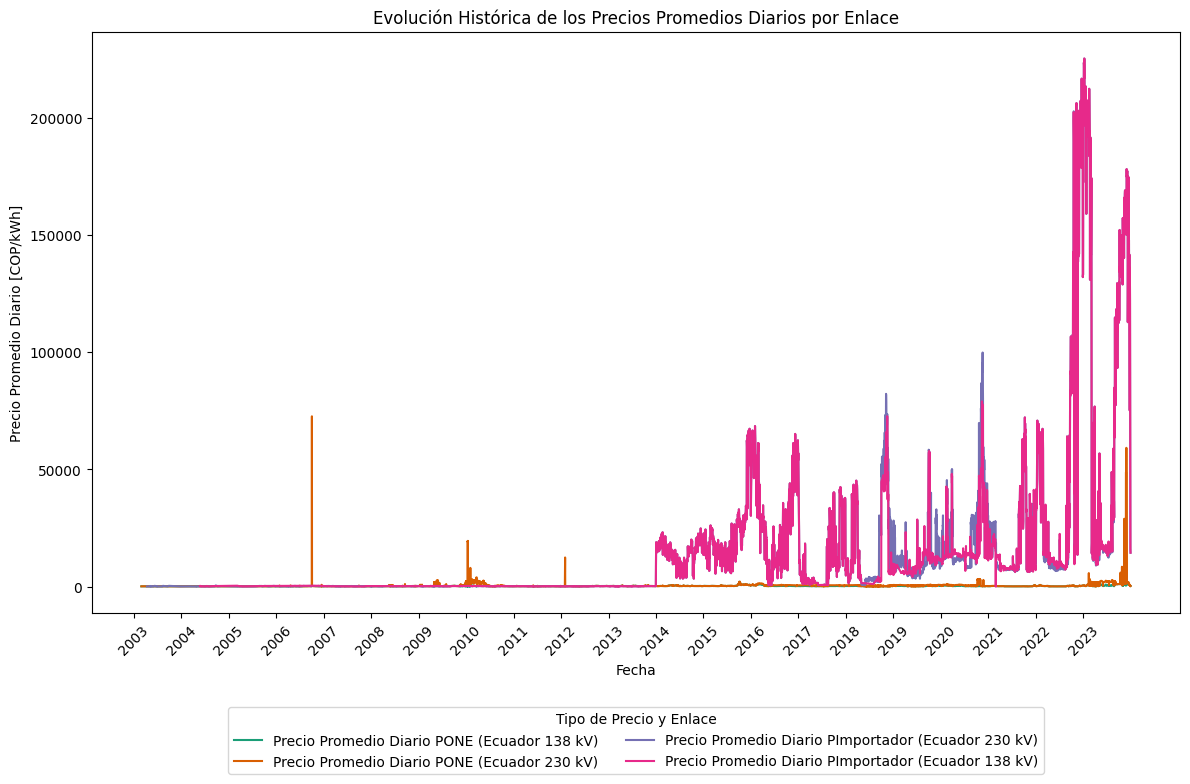

Data saved to Data_Analysis/Precios_Promedios_Diarios_PONE_PImportador_por_Enlace_COP_kWh.xlsx


In [29]:
# Function to plot average daily prices
def plot_avg_daily_prices(df1, df2, output_filename):
    # Concatenate the oferta and liquidacion dataframes
    combined_data = pd.concat([
        df1[['Fecha', 'Enlace', 'Precio Promedio Diario', 'Tipo']],
        df2[['Fecha', 'Enlace', 'Precio Promedio Diario', 'Tipo']]
    ])

    # Create a new DataFrame for seaborn
    avg_prices_df = pd.DataFrame({
        'Fecha': combined_data['Fecha'].unique()
    }).sort_values('Fecha')

    # Filter average daily prices by 'Tipo' and 'Enlace', then map to avg_prices_df
    for tipo, enlace in combined_data[['Tipo', 'Enlace']].drop_duplicates().itertuples(index=False):
        # Filter to get a specific 'Tipo' and 'Enlace'
        temp = combined_data[(combined_data['Tipo'] == tipo) & (combined_data['Enlace'] == enlace)]

        # Extract 'Fecha' and 'Precio Promedio Diario' and create a Series with 'Fecha' as index
        daily_avg_series = temp.set_index('Fecha')['Precio Promedio Diario']

        # Map the daily averages to the avg_prices_df using the 'Fecha' as the key
        avg_prices_df[f'Precio Promedio Diario {tipo} ({enlace})'] = avg_prices_df['Fecha'].map(daily_avg_series)

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.lineplot(
        data=avg_prices_df.melt(id_vars='Fecha',
                                var_name='Tipo de Precio y Enlace', 
                                value_name='Precio Promedio Diario'),
        x='Fecha',
        y='Precio Promedio Diario', 
        hue='Tipo de Precio y Enlace',
        palette='Dark2')

    plt.title('Evolución Histórica de los Precios Promedios Diarios por Enlace')
    plt.xlabel('Fecha')
    plt.ylabel('Precio Promedio Diario [COP/kWh]')
    plt.legend(title='Tipo de Precio y Enlace', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

    # Set the x-ticks to be every 5 years
    ax = plt.gca()  # Get the current Axes instance
    ax.xaxis.set_major_locator(plt.MultipleLocator(365 * 5))  # Set major ticks locator to every 5 years
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: pd.to_datetime(x).year))  # Format tick labels to show only the year

    # To ensure we cover 2003 to 2023 despite leap years, set explicit labels
    ax.set_xticks(pd.date_range(start='2003-01-01', end='2023-01-01', freq='1YS'))
    ax.set_xticklabels(range(2003, 2024, 1))

    plt.xticks(rotation=45)
    plt.tight_layout()

    # Show the plot
    plt.show()

    # To save the dataframe into Excel file
    avg_prices_df_path = os.path.join(directory, output_filename)
    avg_prices_df.to_excel(avg_prices_df_path, index=False)
    print(f"Data saved to {avg_prices_df_path}")

# Use the function to plot and save the data
# Between the precio_oferta_colombia_exportador_cop_kwh and precio_liquidacion_exportaciones_cop_kwh
plot_avg_daily_prices(precio_oferta_colombia_exportador_cop_kwh, precio_liquidacion_exportaciones_cop_kwh, "Precios_Promedios_Diarios_PONE_PLiqExportaciones_por_Enlace_COP_kWh.xlsx")

# Between the precio_oferta_colombia_exportador_cop_kwh and precio_oferta_pais_importador_cop_kwh
plot_avg_daily_prices(precio_oferta_colombia_exportador_cop_kwh, precio_oferta_pais_importador_cop_kwh, "Precios_Promedios_Diarios_PONE_PImportador_por_Enlace_COP_kWh.xlsx")

## Descriptive Statistics

In [30]:
# Function to calculate extended descriptive statistics for each hour by Enlace
def calculate_extended_descriptive_stats_by_enlace(df):
    grouped = df.groupby('Enlace')
    stats_list = []

    for name, group in grouped:
        hours_columns = group.columns[2:26]  # Assuming the hour columns are from the 3rd to 26th column
        descriptive_stats = group[hours_columns].describe().T
        
        # Calculating additional statistics
        descriptive_stats['Variance'] = group[hours_columns].var(axis=0)
        descriptive_stats['Skewness'] = group[hours_columns].skew(axis=0)
        descriptive_stats['Kurtosis'] = group[hours_columns].kurtosis(axis=0)
        descriptive_stats['Range'] = descriptive_stats['max'] - descriptive_stats['min']
        
        # Adding the Enlace column
        descriptive_stats.insert(0, 'Enlace', name)
        
        # Adding the hour column for easier identification
        descriptive_stats.insert(1, 'Hour', descriptive_stats.index)
        
        stats_list.append(descriptive_stats)
    
    return pd.concat(stats_list).reset_index(drop=True)

# Calculate extended descriptive statistics for each dataframe
extended_stats_oferta_colombia_exportador = calculate_extended_descriptive_stats_by_enlace(precio_oferta_colombia_exportador_cop_kwh)
extended_stats_liquidacion_exportaciones = calculate_extended_descriptive_stats_by_enlace(precio_liquidacion_exportaciones_cop_kwh)
extended_stats_oferta_pais_importador = calculate_extended_descriptive_stats_by_enlace(precio_oferta_pais_importador_cop_kwh)
extended_stats_liquidacion_importaciones = calculate_extended_descriptive_stats_by_enlace(precio_liquidacion_importaciones_cop_kwh)

extended_stats_oferta_colombia_exportador.to_excel(f"{directory}/Extended_Stats_Precio_Oferta_Colombia_Exportador.xlsx", index=False)
extended_stats_liquidacion_exportaciones.to_excel(f"{directory}/Extended_Stats_Precio_Liquidacion_Exportaciones.xlsx", index=False)
extended_stats_oferta_pais_importador.to_excel(f"{directory}/Extended_Stats_Precio_Oferta_Pais_Importador.xlsx", index=False)
extended_stats_liquidacion_importaciones.to_excel(f"{directory}/Extended_Stats_Precio_Liquidacion_Importaciones.xlsx", index=False)

## Analysis - Level of Market Integration

The (static) degree of integration towards a single market that the energy market between Colombia and Ecuador has reached.

### All Years Aggregated

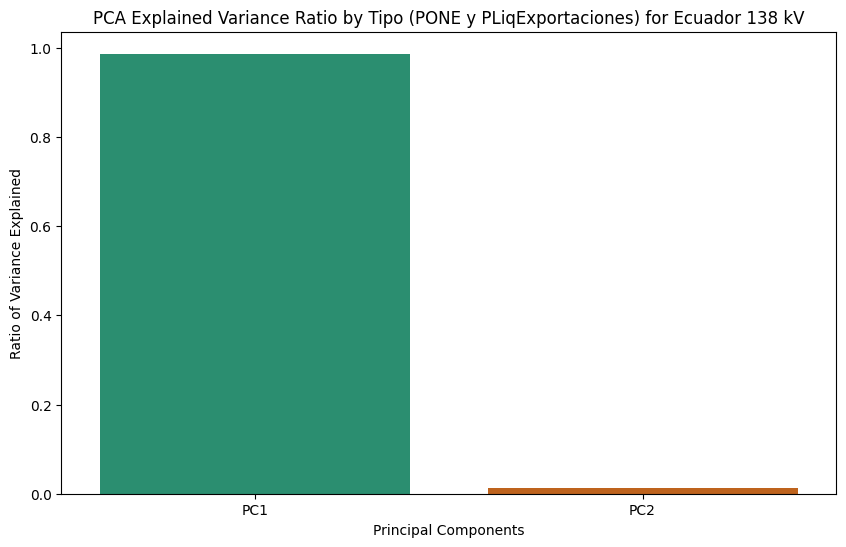

Explained variance by each component for Ecuador 138 kV: [0.98661754 0.01338246]
Cumulative explained variance for Ecuador 138 kV: [0.98661754 1.        ]


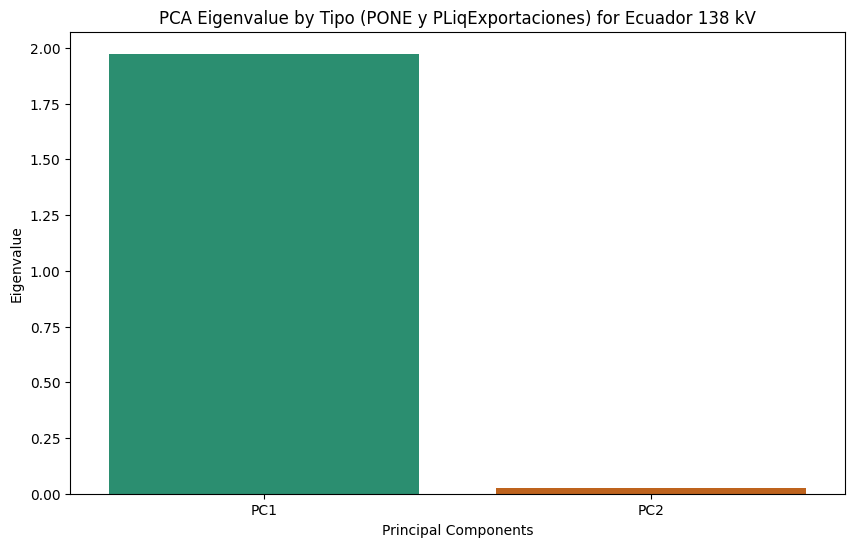

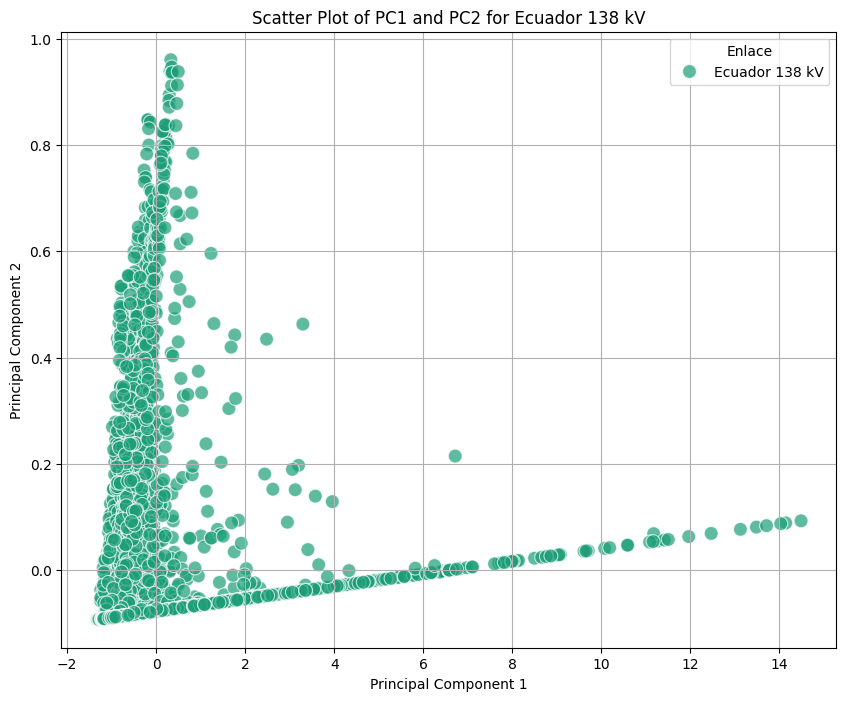

   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.973498     0.00000     98.66%     98.66%
1          2    0.026768    -1.94673      1.34%    100.00%
Component Loadings for Ecuador 138 kV: [[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]


Pivoted data saved to Data_Analysis/PCA_Pivoted_Data_PONE_PLiqExportaciones_Ecuador_138_kV.xlsx
   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.973498     0.00000     98.66%     98.66%
1          2    0.026768    -1.94673      1.34%    100.00%
Component Loadings for Ecuador 138 kV: [[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]


Pivoted data saved to Data_Analysis/PCA_Pivoted_Data_PONE_PLiqExportaciones_Ecuador_138_kV.xlsx


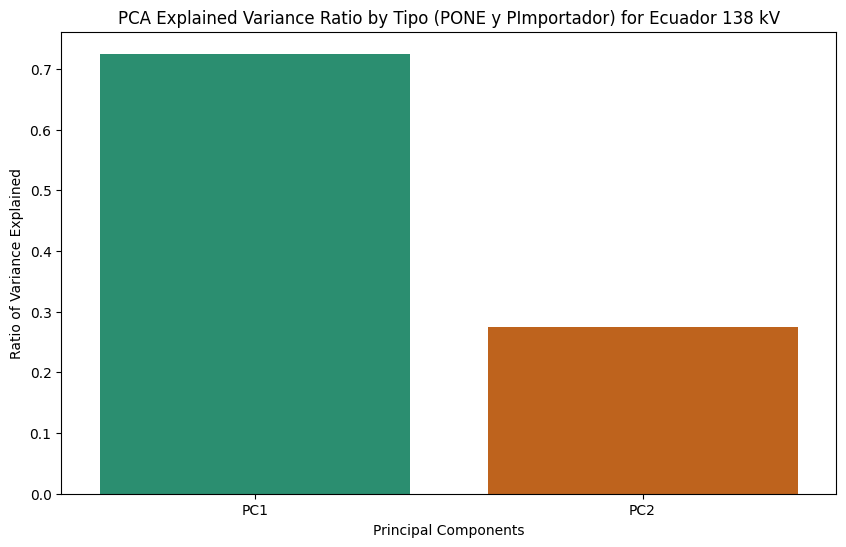

Explained variance by each component for Ecuador 138 kV: [0.72508017 0.27491983]
Cumulative explained variance for Ecuador 138 kV: [0.72508017 1.        ]


   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.450446    0.000000     72.51%     72.51%
1          2    0.549948   -0.900498     27.49%    100.00%
Component Loadings for Ecuador 138 kV: [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


Pivoted data saved to Data_Analysis/PCA_Pivoted_Data_PONE_PImportador_Ecuador_138_kV.xlsx
   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.450446    0.000000     72.51%     72.51%
1          2    0.549948   -0.900498     27.49%    100.00%
Component Loadings for Ecuador 138 kV: [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


Pivoted data saved to Data_Analysis/PCA_Pivoted_Data_PONE_PImportador_Ecuador_138_kV.xlsx


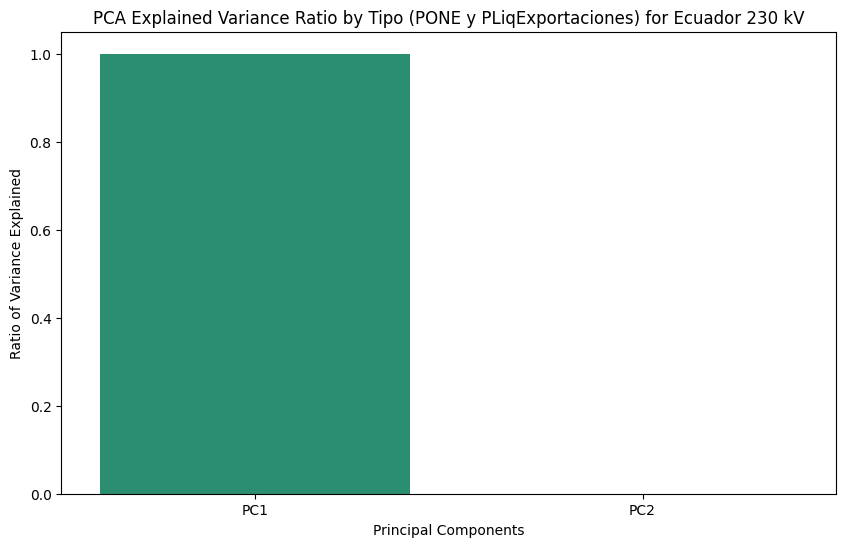

Explained variance by each component for Ecuador 230 kV: [9.99755074e-01 2.44925798e-04]
Cumulative explained variance for Ecuador 230 kV: [0.99975507 1.        ]


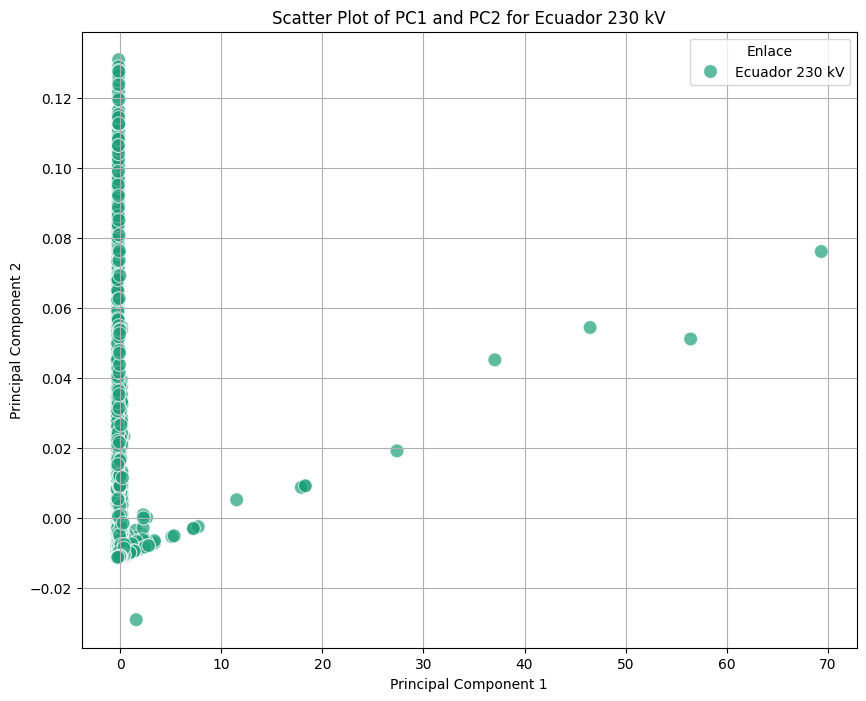

   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.999777    0.000000     99.98%     99.98%
1          2    0.000490   -1.999287      0.02%    100.00%
Component Loadings for Ecuador 230 kV: [[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]


Pivoted data saved to Data_Analysis/PCA_Pivoted_Data_PONE_PLiqExportaciones_Ecuador_230_kV.xlsx
   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.999777    0.000000     99.98%     99.98%
1          2    0.000490   -1.999287      0.02%    100.00%
Component Loadings for Ecuador 230 kV: [[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]


Pivoted data saved to Data_Analysis/PCA_Pivoted_Data_PONE_PLiqExportaciones_Ecuador_230_kV.xlsx


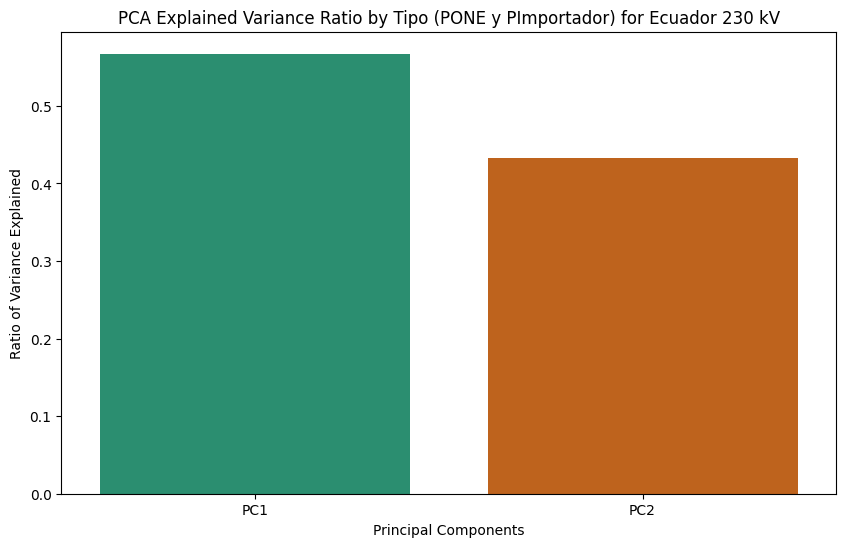

Explained variance by each component for Ecuador 230 kV: [0.56715529 0.43284471]
Cumulative explained variance for Ecuador 230 kV: [0.56715529 1.        ]


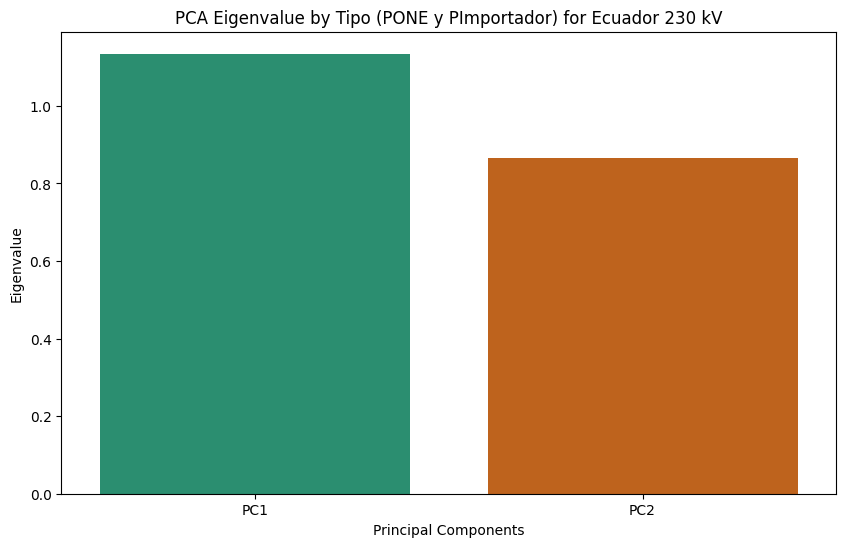

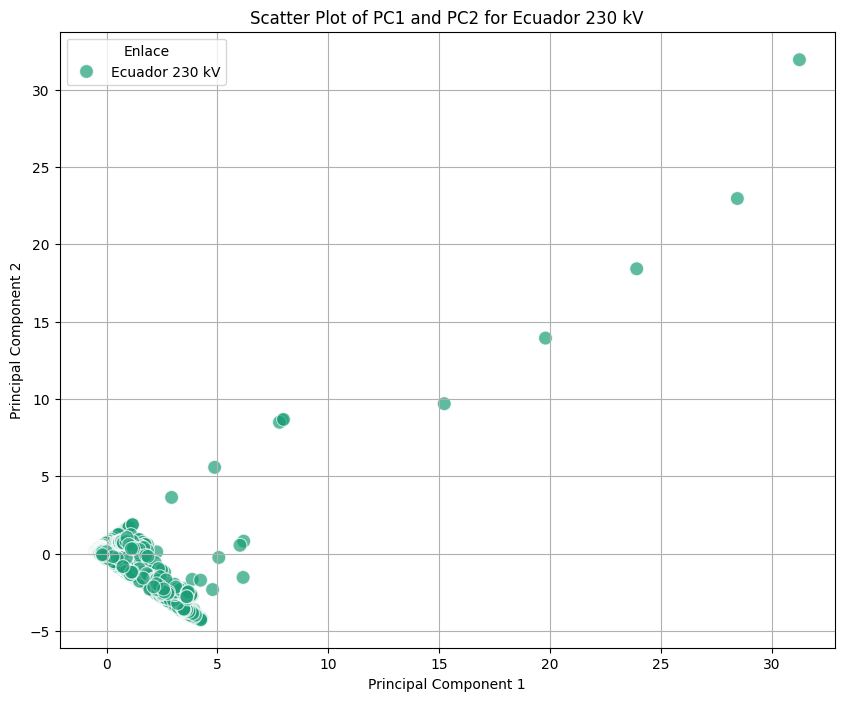

   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.134494    0.000000     56.72%     56.72%
1          2    0.865829   -0.268665     43.28%    100.00%
Component Loadings for Ecuador 230 kV: [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


Pivoted data saved to Data_Analysis/PCA_Pivoted_Data_PONE_PImportador_Ecuador_230_kV.xlsx
   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.134494    0.000000     56.72%     56.72%
1          2    0.865829   -0.268665     43.28%    100.00%
Component Loadings for Ecuador 230 kV: [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


Pivoted data saved to Data_Analysis/PCA_Pivoted_Data_PONE_PImportador_Ecuador_230_kV.xlsx


In [84]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Function to perform PCA analysis
def perform_pca_analysis_by_tipo(df1, df2, enlace, output_pivot_filename):
    # Combine the dataframes
    combined_data = pd.concat([
        df1[['Fecha', 'Enlace', 'Tipo', 'Precio Promedio Diario']],
        df2[['Fecha', 'Enlace', 'Tipo', 'Precio Promedio Diario']]
    ])

    # Filter data for the specified Enlace
    filtered_data = combined_data[combined_data['Enlace'] == enlace]

    # Pivot so that each 'Tipo' becomes a column
    pivoted_data = filtered_data.pivot_table(index='Fecha', columns='Tipo', values='Precio Promedio Diario')
 
    # Drop any rows with missing data to simplify the example
    pivoted_data.dropna(inplace=True)

    # Standardizing the pivoted data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(pivoted_data)

    # Applying PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    component_loadings = pca.components_

    # Plotting the explained variance
    plt.figure(figsize=(10, 6))
    sns.barplot(x=['PC1', 'PC2'], y=explained_variance_ratio, palette='Dark2')
    plt.title(f'PCA Explained Variance Ratio by Tipo ({df1['Tipo'].unique()[0]} y {df2['Tipo'].unique()[0]}) for {enlace}')
    plt.ylabel('Ratio of Variance Explained')
    plt.xlabel('Principal Components')
    plt.show()

    # Display detailed variance information
    print(f"Explained variance by each component for {enlace}: {explained_variance_ratio}")
    print(f"Cumulative explained variance for {enlace}: {np.cumsum(explained_variance_ratio)}")

    # Create DataFrame to display PCA results in a table
    components = range(1, len(explained_variance_ratio) + 1)
    eigenvalues = pca.explained_variance_
    differences = np.diff(eigenvalues, prepend=eigenvalues[0])  # Prepend to include the first entry
    proportions = explained_variance_ratio
    cumulative = np.cumsum(explained_variance_ratio)

    pca_table = pd.DataFrame({
        'Component': components,
        'Eigenvalue': eigenvalues,
        'Difference': differences,
        'Proportion': proportions,
        'Cumulative': cumulative
    })

    # Formatting proportions and cumulative as percentages
    pca_table['Proportion'] = pca_table['Proportion'].apply(lambda x: f"{x:.2%}")
    pca_table['Cumulative'] = pca_table['Cumulative'].apply(lambda x: f"{x:.2%}")

    # Plotting the explained variance
    plt.figure(figsize=(10, 6))
    sns.barplot(x=['PC1', 'PC2'], y='Eigenvalue', data=pca_table, palette='Dark2')
    plt.title(f'PCA Eigenvalue by Tipo ({df1['Tipo'].unique()[0]} y {df2['Tipo'].unique()[0]}) for {enlace}')
    plt.ylabel('Eigenvalue')
    plt.xlabel('Principal Components')
    plt.show()

    # Create a DataFrame from principal components for easier plotting
    principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    principal_df['Fecha'] = pivoted_data.index

    # Ensure the 'Fecha' columns in both DataFrames have the same data type
    principal_df['Fecha'] = pd.to_datetime(principal_df['Fecha'])
    filtered_data['Fecha'] = pd.to_datetime(filtered_data['Fecha'])

    # Re-merge the 'Enlace' column back to principal_df
    enlace_data = filtered_data[['Fecha', 'Enlace']].drop_duplicates().set_index('Fecha')
    principal_df = principal_df.merge(enlace_data, left_on='Fecha', right_index=True)

    # Scatter plot of PC1 vs PC2 using seaborn, colored by 'Enlace'
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(x='PC1', y='PC2', hue='Enlace', data=principal_df, alpha=0.7, s=100, palette='Dark2')
    plt.title(f'Scatter Plot of PC1 and PC2 for {enlace}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.legend(title='Enlace')
    plt.show()

    # Print the PCA results table
    print(pca_table)
    # Display the Component Loadings
    print(f"Component Loadings for {enlace}: {component_loadings}")
    print("\n")

    # Save the pivoted data
    pivoted_data_copy = pivoted_data.copy().reset_index()
    pivoted_data_copy_df_path = os.path.join(directory, output_pivot_filename)
    pivoted_data_copy.to_excel(pivoted_data_copy_df_path, index=False)
    print(f"Pivoted data saved to {pivoted_data_copy_df_path}")

    # Print the PCA results table
    print(pca_table)
    # Display the Component Loadings
    print(f"Component Loadings for {enlace}: {component_loadings}")
    print("\n")

    # Save the pivoted data
    pivoted_data_copy = pivoted_data.copy().reset_index()
    pivoted_data_copy_df_path = os.path.join(directory, output_pivot_filename)
    pivoted_data_copy.to_excel(pivoted_data_copy_df_path, index=False)
    print(f"Pivoted data saved to {pivoted_data_copy_df_path}")

# Perform PCA analysis for each Enlace
enlaces = ['Ecuador 138 kV', 'Ecuador 230 kV']
for enlace in enlaces:
    perform_pca_analysis_by_tipo(precio_oferta_colombia_exportador_cop_kwh, precio_liquidacion_exportaciones_cop_kwh, enlace, f"PCA_Pivoted_Data_PONE_PLiqExportaciones_{enlace.replace(' ', '_')}.xlsx")
    perform_pca_analysis_by_tipo(precio_oferta_colombia_exportador_cop_kwh, precio_oferta_pais_importador_cop_kwh, enlace, f"PCA_Pivoted_Data_PONE_PImportador_{enlace.replace(' ', '_')}.xlsx")

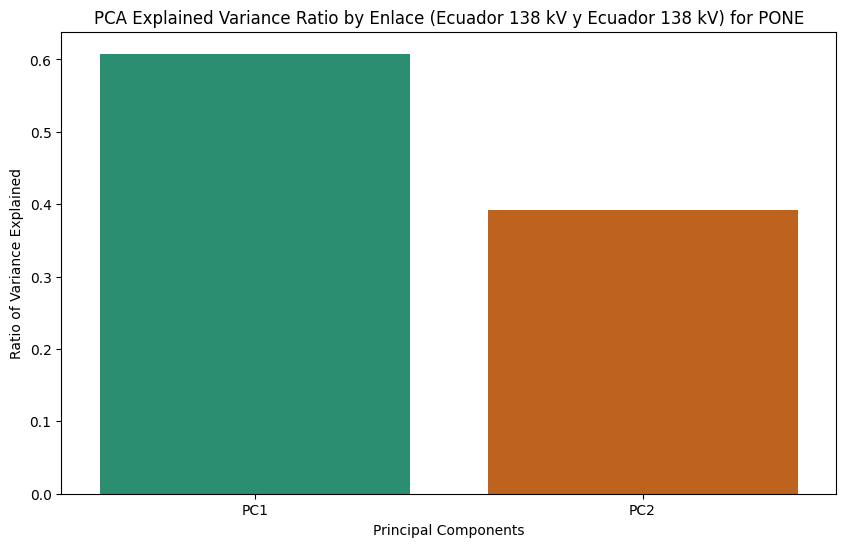

Explained variance by each component for PONE: [0.6078369 0.3921631]
Cumulative explained variance for PONE: [0.6078369 1.       ]


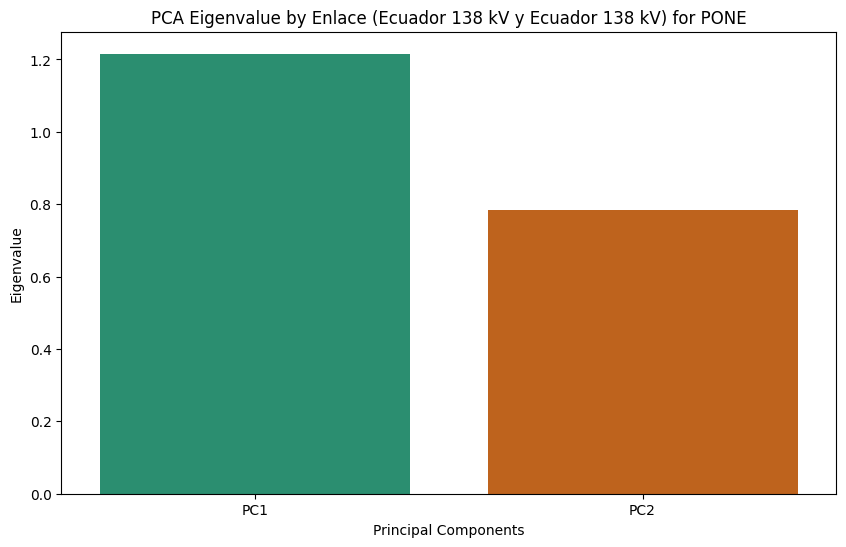

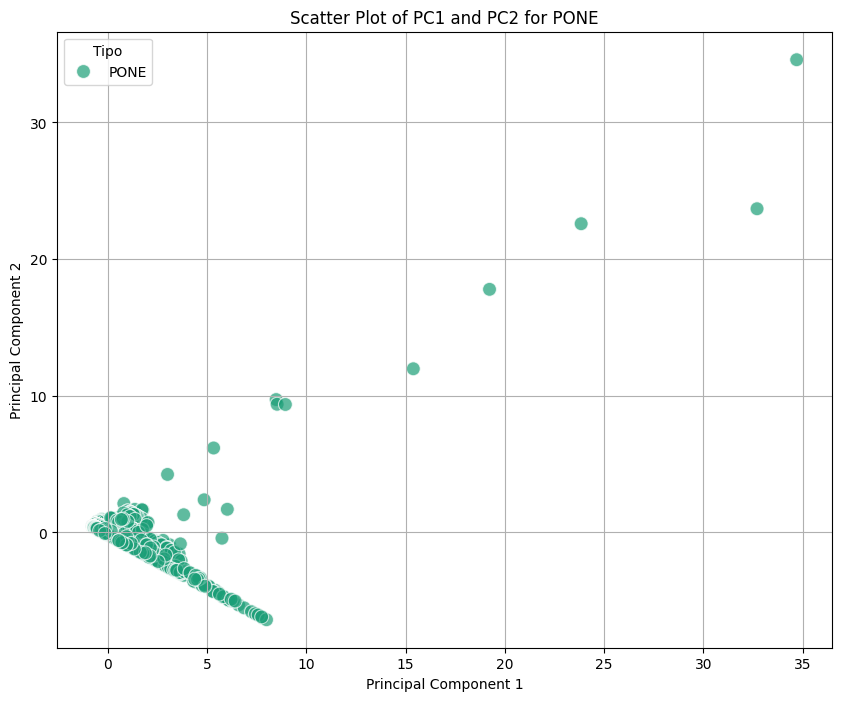

   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.215836    0.000000     60.78%     60.78%
1          2    0.784431   -0.431405     39.22%    100.00%
Component Loadings: [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


Pivoted data saved to Data_Analysis/PCA_Pivoted_Data_Enlace_PONE.xlsx


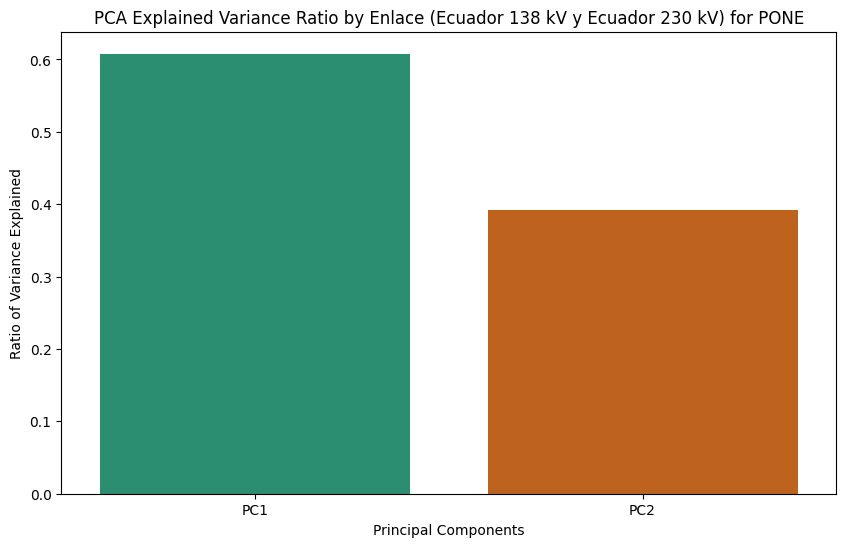

Explained variance by each component for PONE: [0.6078369 0.3921631]
Cumulative explained variance for PONE: [0.6078369 1.       ]


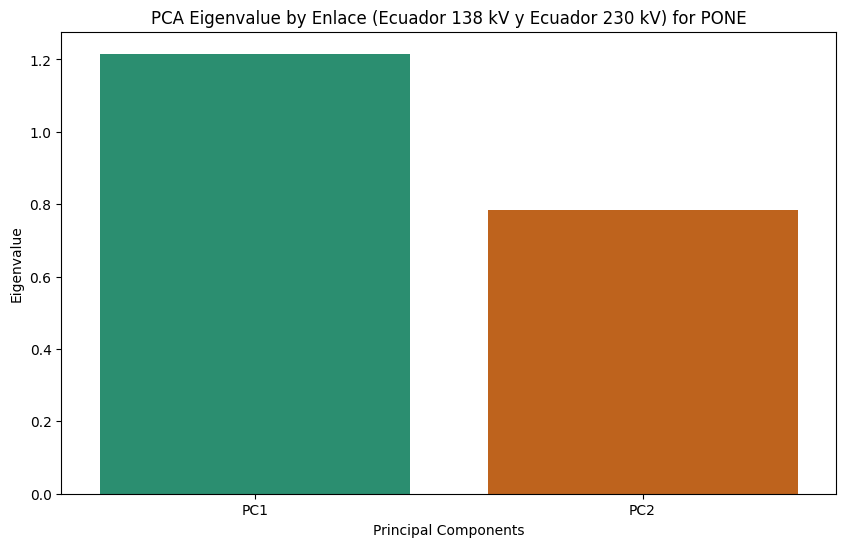

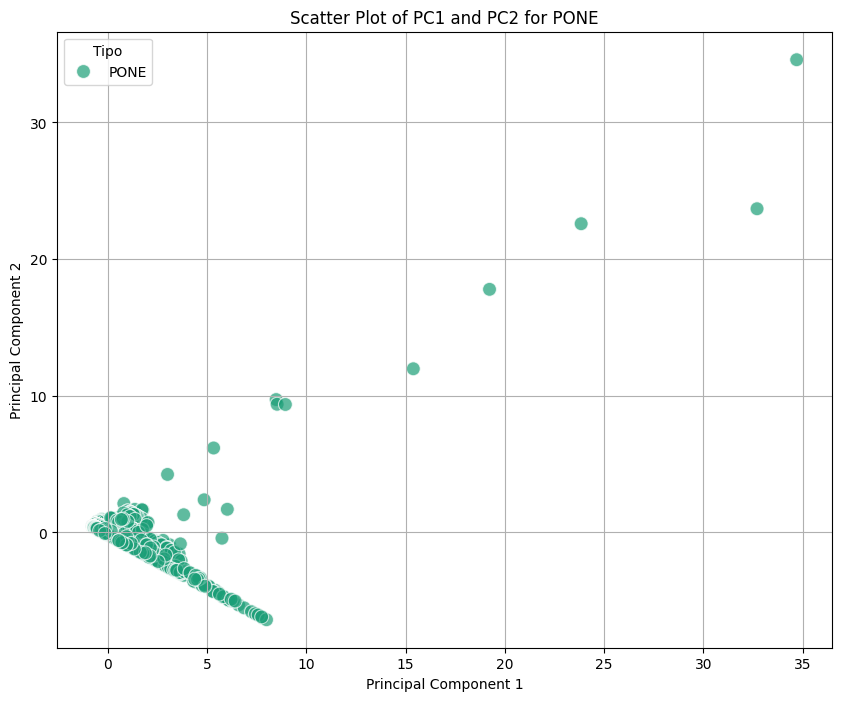

   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.215836    0.000000     60.78%     60.78%
1          2    0.784431   -0.431405     39.22%    100.00%
Component Loadings: [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


Pivoted data saved to Data_Analysis/PCA_Pivoted_Data_Enlace_PONE.xlsx


ValueError: at least one array or dtype is required

In [87]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Function to perform PCA analysis
def perform_pca_analysis_by_enlace(df1, df2, tipo, output_pivot_filename):
    # Combine the dataframes
    combined_data = pd.concat([
        df1[['Fecha', 'Enlace', 'Tipo', 'Precio Promedio Diario']],
        df2[['Fecha', 'Enlace', 'Tipo', 'Precio Promedio Diario']]
    ])

    # Filter data for the specified Tipo
    filtered_data = combined_data[combined_data['Tipo'] == tipo]

    # Pivot so that each 'Enlace' becomes a column
    pivoted_data = filtered_data.pivot_table(index='Fecha', columns='Enlace', values='Precio Promedio Diario')
    
    # Drop any rows with missing data to simplify the example
    pivoted_data.dropna(inplace=True)

    # Standardizing the pivoted data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(pivoted_data)

    # Applying PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    component_loadings = pca.components_

    # Plotting the explained variance
    plt.figure(figsize=(10, 6))
    sns.barplot(x=['PC1', 'PC2'], y=explained_variance_ratio, palette='Dark2')
    plt.title(f'PCA Explained Variance Ratio by Enlace ({df1['Enlace'].unique()[0]} y {df2['Enlace'].unique()[0]}) for {tipo}')
    plt.ylabel('Ratio of Variance Explained')
    plt.xlabel('Principal Components')
    plt.show()

    # Display detailed variance information
    print(f"Explained variance by each component for {tipo}:", explained_variance_ratio)
    print(f"Cumulative explained variance for {tipo}:", np.cumsum(explained_variance_ratio))

    # Create DataFrame to display PCA results in a table
    components = range(1, len(explained_variance_ratio) + 1)
    eigenvalues = pca.explained_variance_
    differences = np.diff(eigenvalues, prepend=eigenvalues[0])  # Prepend to include the first entry
    proportions = explained_variance_ratio
    cumulative = np.cumsum(explained_variance_ratio)

    pca_table = pd.DataFrame({
        'Component': components,
        'Eigenvalue': eigenvalues,
        'Difference': differences,
        'Proportion': proportions,
        'Cumulative': cumulative
    })

    # Formatting proportions and cumulative as percentages
    pca_table['Proportion'] = pca_table['Proportion'].apply(lambda x: f"{x:.2%}")
    pca_table['Cumulative'] = pca_table['Cumulative'].apply(lambda x: f"{x:.2%}")

    # Plotting the explained variance
    plt.figure(figsize=(10, 6))
    sns.barplot(x=['PC1', 'PC2'], y='Eigenvalue', data=pca_table, palette='Dark2')
    plt.title(f'PCA Eigenvalue by Enlace ({df1['Enlace'].unique()[0]} y {df2['Enlace'].unique()[0]}) for {tipo}')
    plt.ylabel('Eigenvalue')
    plt.xlabel('Principal Components')
    plt.show()

    # Create a DataFrame from principal components for easier plotting
    principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    principal_df['Fecha'] = pivoted_data.index

    # Ensure the 'Fecha' columns in both DataFrames have the same data type
    principal_df['Fecha'] = pd.to_datetime(principal_df['Fecha'])
    filtered_data['Fecha'] = pd.to_datetime(filtered_data['Fecha'])

    # Re-merge the 'Tipo' column back to principal_df
    tipo_data = filtered_data[['Fecha', 'Tipo']].drop_duplicates().set_index('Fecha')
    principal_df = principal_df.merge(tipo_data, left_on='Fecha', right_index=True)

    # Scatter plot of PC1 vs PC2 using seaborn, colored by 'Tipo'
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(x='PC1', y='PC2', hue='Tipo', data=principal_df, alpha=0.7, s=100, palette='Dark2')
    plt.title(f'Scatter Plot of PC1 and PC2 for {tipo}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.legend(title='Tipo')
    plt.show()

    # Print the PCA results table
    print(pca_table)
    # Display the Component Loadings
    print("Component Loadings:", component_loadings)
    print("\n")

    # Save the pivoted data
    pivoted_data_copy = pivoted_data.copy().reset_index()
    pivoted_data_copy_df_path = os.path.join(directory, output_pivot_filename)
    pivoted_data_copy.to_excel(pivoted_data_copy_df_path, index=False)
    print(f"Pivoted data saved to {pivoted_data_copy_df_path}")

# Perform PCA analysis for each Enlace
tipos = ['PONE', 'PImportador']
for tipo in tipos:
    perform_pca_analysis_by_enlace(precio_oferta_colombia_exportador_cop_kwh, precio_liquidacion_exportaciones_cop_kwh, tipo, f"PCA_Pivoted_Data_Enlace_{tipo.replace(' ', '_')}.xlsx")
    perform_pca_analysis_by_enlace(precio_oferta_colombia_exportador_cop_kwh, precio_oferta_pais_importador_cop_kwh, tipo, f"PCA_Pivoted_Data_Enlace_{tipo.replace(' ', '_')}.xlsx")

### Evolution Per Year

In [88]:
# Load the pivoted data for PONE and PLiqExportaciones
pivoted_data_path = os.path.join(directory, "PCA_Pivoted_Data_PONE_PLiqExportaciones_por_Enlace.xlsx")
pivoted_data = pd.read_excel(pivoted_data_path, index_col=[0, 1], parse_dates=['Fecha'])

# Segment data annually
annual_data = {year: df for year, df in pivoted_data.groupby(pivoted_data.index.get_level_values('Fecha').year)}

# Prepare to collect annual PCA tables
annual_pca_tables = []

for year, data in annual_data.items():
    if data.dropna().empty:
        continue  # Skip years with insufficient data

    # Standardizing the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.dropna())

    # Applying PCA
    pca = PCA(n_components=2)  # Adjust components based on specific analysis needs
    pca.fit(data_scaled)

    # Gather PCA results
    eigenvalues = pca.explained_variance_
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Prepare PCA table for the current year
    pca_table = pd.DataFrame({
        'Component': range(1, len(eigenvalues) + 1),
        'Eigenvalue': eigenvalues,
        'Difference': np.diff(eigenvalues, prepend=eigenvalues[0]),
        'Proportion': explained_variance_ratio,
        'Cumulative': cumulative_variance
    })

    # Formatting percentages for clarity
    pca_table['Proportion'] = pca_table['Proportion'].apply(lambda x: f"{x:.2%}")
    pca_table['Cumulative'] = pca_table['Cumulative'].apply(lambda x: f"{x:.2%}")

    # Collecting annual results
    annual_pca_tables.append((year, pca_table))

# Print out the PCA tables individually for each year
for year, table in annual_pca_tables:
    print(f"Year: {year}")
    print(table)
    print("\n")

# Prepare a list to store DataFrames for concatenation
df_list = []

# Iterate through the annual results and add them to the list
for year, table in annual_pca_tables:
    table['Year'] = year  # Add the 'Year' column to each table
    df_list.append(table)

# Concatenate all annual PCA tables into one DataFrame
concatenated_pca_table = pd.concat(df_list, ignore_index=True)

# Make 'Year' the first column
concatenated_pca_table = concatenated_pca_table[['Year'] + [col for col in concatenated_pca_table if col != 'Year']]

# Now you have a single DataFrame with all the annual PCA results
print(concatenated_pca_table)
concatenated_pca_table_path = os.path.join(directory, "PCA_Evolution_Per_Year_PONE_PLiqExportaciones.xlsx")
concatenated_pca_table.to_excel(concatenated_pca_table_path, index=False)
print(f"Concatenated PCA table saved to {concatenated_pca_table_path}")

Year: 2003
   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.991581    0.000000     99.42%     99.42%
1          2    0.011692   -1.979889      0.58%    100.00%


Year: 2004
   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.983766    0.000000     99.05%     99.05%
1          2    0.018977   -1.964789      0.95%    100.00%


Year: 2005
   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.989136     0.00000     99.32%     99.32%
1          2    0.013615    -1.97552      0.68%    100.00%


Year: 2006
   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.098245     0.00000     54.84%     54.84%
1          2    0.904506    -0.19374     45.16%    100.00%


Year: 2007
   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.851836    0.000000     92.46%     92.46%
1          2    0.150915   -1.700921      7.54%    100.00%


Year: 2008
   Component  Eigenvalue  Difference Pr

In [89]:
# Load the pivoted data for PONE and PImportador
pivoted_data_path = os.path.join(directory, "PCA_Pivoted_Data_PONE_PImportador_por_Enlace.xlsx")
pivoted_data = pd.read_excel(pivoted_data_path, index_col=[0, 1], parse_dates=['Fecha'])

# Segment data annually
annual_data = {year: df for year, df in pivoted_data.groupby(pivoted_data.index.get_level_values('Fecha').year)}

# Prepare to collect annual PCA tables
annual_pca_tables = []

for year, data in annual_data.items():
    if data.dropna().empty:
        continue  # Skip years with insufficient data

    # Standardizing the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.dropna())

    # Applying PCA
    pca = PCA(n_components=2)  # Adjust components based on specific analysis needs
    pca.fit(data_scaled)

    # Gather PCA results
    eigenvalues = pca.explained_variance_
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Prepare PCA table for the current year
    pca_table = pd.DataFrame({
        'Component': range(1, len(eigenvalues) + 1),
        'Eigenvalue': eigenvalues,
        'Difference': np.diff(eigenvalues, prepend=eigenvalues[0]),
        'Proportion': explained_variance_ratio,
        'Cumulative': cumulative_variance
    })

    # Formatting percentages for clarity
    pca_table['Proportion'] = pca_table['Proportion'].apply(lambda x: f"{x:.2%}")
    pca_table['Cumulative'] = pca_table['Cumulative'].apply(lambda x: f"{x:.2%}")

    # Collecting annual results
    annual_pca_tables.append((year, pca_table))

# Print out the PCA tables individually for each year
for year, table in annual_pca_tables:
    print(f"Year: {year}")
    print(table)
    print("\n")

# Prepare a list to store DataFrames for concatenation
df_list = []

# Iterate through the annual results and add them to the list
for year, table in annual_pca_tables:
    table['Year'] = year  # Add the 'Year' column to each table
    df_list.append(table)

# Concatenate all annual PCA tables into one DataFrame
concatenated_pca_table = pd.concat(df_list, ignore_index=True)

# Make 'Year' the first column
concatenated_pca_table = concatenated_pca_table[['Year'] + [col for col in concatenated_pca_table if col != 'Year']]

# Now you have a single DataFrame with all the annual PCA results
print(concatenated_pca_table)
concatenated_pca_table_path = os.path.join(directory, "PCA_Evolution_Per_Year_PONE_PImportador.xlsx")
concatenated_pca_table.to_excel(concatenated_pca_table_path, index=False)
print(f"Concatenated PCA table saved to {concatenated_pca_table_path}")

Year: 2003
   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.631535    0.000000     81.31%     81.31%
1          2    0.375023   -1.256512     18.69%    100.00%


Year: 2004
   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.529536    0.000000     76.27%     76.27%
1          2    0.475840   -1.053696     23.73%    100.00%


Year: 2005
   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.261752    0.000000     62.92%     62.92%
1          2    0.743698   -0.518054     37.08%    100.00%


Year: 2006
   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.142663    0.000000     56.98%     56.98%
1          2    0.862801   -0.279862     43.02%    100.00%


Year: 2007
   Component  Eigenvalue  Difference Proportion Cumulative
0          1    1.580470    0.000000     78.81%     78.81%
1          2    0.424994   -1.155477     21.19%    100.00%


Year: 2008
   Component  Eigenvalue  Difference Pr

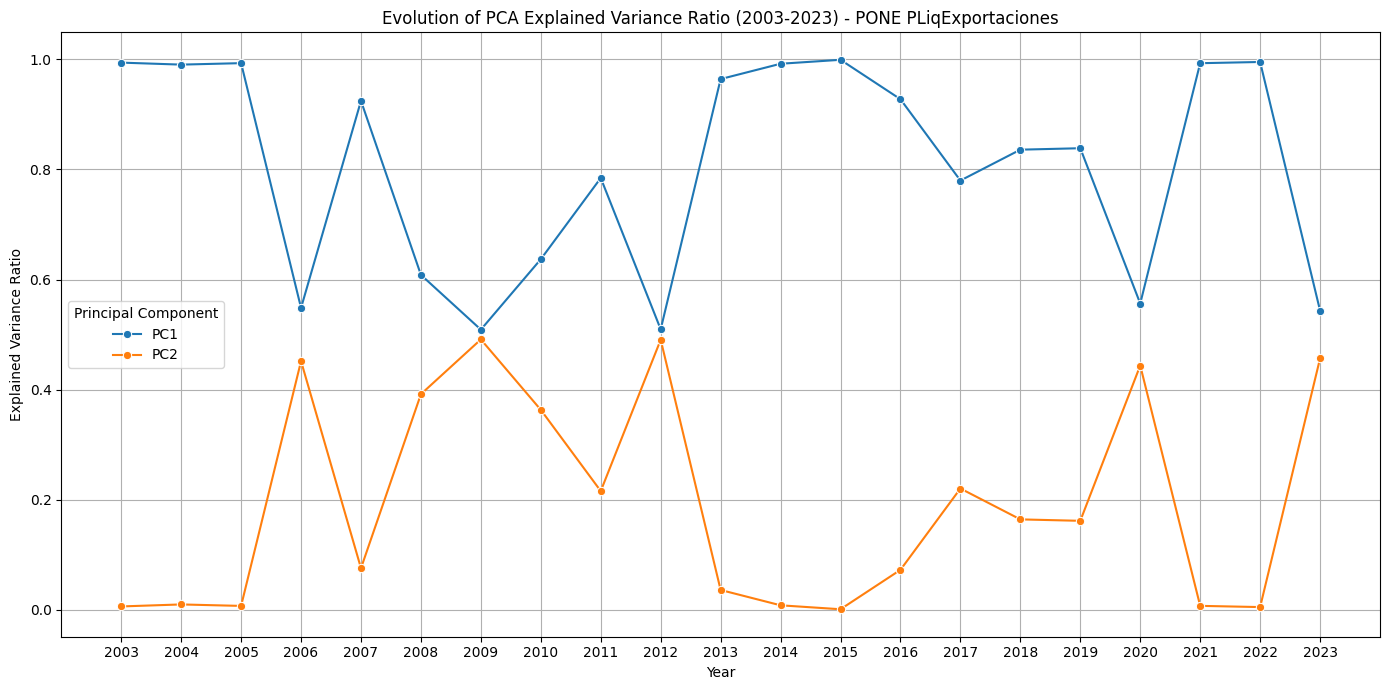

    Year         Feature       PC1       PC2
0   2003  Ecuador 138 kV  0.707107  0.707107
1   2003  Ecuador 230 kV  0.707107 -0.707107
2   2004  Ecuador 138 kV  0.707107 -0.707107
3   2004  Ecuador 230 kV  0.707107  0.707107
4   2005  Ecuador 138 kV  0.707107 -0.707107
5   2005  Ecuador 230 kV  0.707107  0.707107
6   2006  Ecuador 138 kV  0.707107 -0.707107
7   2006  Ecuador 230 kV  0.707107  0.707107
8   2007  Ecuador 138 kV  0.707107 -0.707107
9   2007  Ecuador 230 kV  0.707107  0.707107
10  2008  Ecuador 138 kV  0.707107 -0.707107
11  2008  Ecuador 230 kV  0.707107  0.707107
12  2009  Ecuador 138 kV  0.707107 -0.707107
13  2009  Ecuador 230 kV  0.707107  0.707107
14  2010  Ecuador 138 kV  0.707107 -0.707107
15  2010  Ecuador 230 kV  0.707107  0.707107
16  2011  Ecuador 138 kV  0.707107 -0.707107
17  2011  Ecuador 230 kV  0.707107  0.707107
18  2012  Ecuador 138 kV  0.707107 -0.707107
19  2012  Ecuador 230 kV  0.707107  0.707107
20  2013  Ecuador 138 kV  0.707107 -0.707107
21  2013  

In [90]:
# Load the pivoted data for PONE and PLiqExportaciones
pivoted_data_path = os.path.join(directory, "PCA_Pivoted_Data_PONE_PLiqExportaciones_por_Enlace.xlsx")
pivoted_data = pd.read_excel(pivoted_data_path, index_col=[0, 1], parse_dates=['Fecha'])

# Segment data annually
annual_data = {year: df for year, df in pivoted_data.groupby(pivoted_data.index.get_level_values('Fecha').year)}

# Prepare to collect explained variance ratios for plotting
explained_variance_ratios = {
    'Year': [],
    'PC1 Variance Explained': [],
    'PC2 Variance Explained': []
}

# Initialize a list to hold data for the component loadings table
component_loadings_list = []

for year, data in annual_data.items():
    if data.dropna().empty:
        continue  # Skip years with insufficient data

    # Standardizing the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.dropna())

    # Applying PCA
    pca = PCA(n_components=2)
    pca.fit(data_scaled)

    # Store the explained variance ratio for each component
    explained_variance_ratios['Year'].append(year)
    explained_variance_ratios['PC1 Variance Explained'].append(pca.explained_variance_ratio_[0])
    explained_variance_ratios['PC2 Variance Explained'].append(pca.explained_variance_ratio_[1] if len(pca.explained_variance_ratio_) > 1 else 0)

    # Create a DataFrame for the loadings of each principal component
    loadings_df = pd.DataFrame(
        pca.components_.T,  # Transpose so that components are columns
        columns=[f'PC{index+1}' for index in range(pca.n_components_)],
        index=data.columns  # The feature names should be the index
    )
    loadings_df['Year'] = year  # Add the 'Year' column

    # Append the DataFrame to the list
    component_loadings_list.append(loadings_df)

# Convert collected data to DataFrame for plotting
df_variance_ratios = pd.DataFrame(explained_variance_ratios)

# Plotting the explained variance over years with clear x-axis ticks
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_variance_ratios, x='Year', y='PC1 Variance Explained', label='PC1', marker='o')
sns.lineplot(data=df_variance_ratios, x='Year', y='PC2 Variance Explained', label='PC2', marker='o')

# Adjust the x-ticks to show each year
plt.xticks(ticks=np.arange(2003, 2024, 1), labels=np.arange(2003, 2024, 1))

plt.title('Evolution of PCA Explained Variance Ratio (2003-2023) - PONE PLiqExportaciones')
plt.xlabel('Year')
plt.ylabel('Explained Variance Ratio')
plt.legend(title='Principal Component')
plt.grid(True)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlap
plt.show()

# Concatenate all the component loadings into one DataFrame
component_loadings_table = pd.concat(component_loadings_list).reset_index()
component_loadings_table.rename(columns={'index': 'Feature'}, inplace=True)

# Reorder the DataFrame to put 'Year' as the first column
cols = ['Year'] + [col for col in component_loadings_table.columns if col != 'Year']
component_loadings_table = component_loadings_table[cols]

# Display the DataFrame
print(component_loadings_table)

# Save the component loadings table
component_loadings_table_path = os.path.join(directory, "Component_Loadings_PONE_PLiqExportaciones.xlsx")
component_loadings_table.to_excel(component_loadings_table_path, index=False)
print(f"Component loadings table saved to {component_loadings_table_path}")

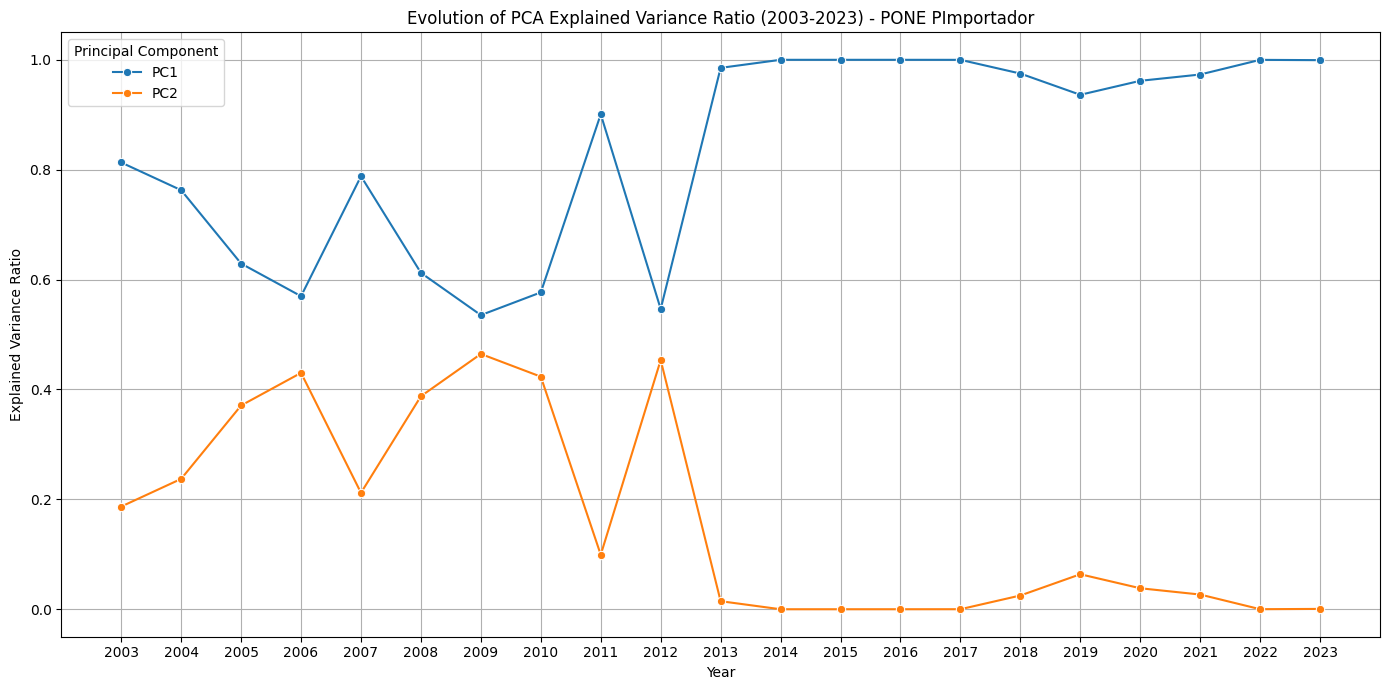

    Year         Feature       PC1       PC2
0   2003  Ecuador 138 kV -0.707107 -0.707107
1   2003  Ecuador 230 kV -0.707107  0.707107
2   2004  Ecuador 138 kV -0.707107  0.707107
3   2004  Ecuador 230 kV -0.707107 -0.707107
4   2005  Ecuador 138 kV  0.707107  0.707107
5   2005  Ecuador 230 kV  0.707107 -0.707107
6   2006  Ecuador 138 kV  0.707107 -0.707107
7   2006  Ecuador 230 kV  0.707107  0.707107
8   2007  Ecuador 138 kV  0.707107 -0.707107
9   2007  Ecuador 230 kV  0.707107  0.707107
10  2008  Ecuador 138 kV  0.707107 -0.707107
11  2008  Ecuador 230 kV  0.707107  0.707107
12  2009  Ecuador 138 kV -0.707107  0.707107
13  2009  Ecuador 230 kV  0.707107  0.707107
14  2010  Ecuador 138 kV  0.707107 -0.707107
15  2010  Ecuador 230 kV  0.707107  0.707107
16  2011  Ecuador 138 kV  0.707107 -0.707107
17  2011  Ecuador 230 kV  0.707107  0.707107
18  2012  Ecuador 138 kV  0.707107 -0.707107
19  2012  Ecuador 230 kV  0.707107  0.707107
20  2013  Ecuador 138 kV  0.707107 -0.707107
21  2013  

In [91]:
# Load the pivoted data for PONE and PImportador
pivoted_data_path = os.path.join(directory, "PCA_Pivoted_Data_PONE_PImportador_por_Enlace.xlsx")
pivoted_data = pd.read_excel(pivoted_data_path, index_col=[0, 1], parse_dates=['Fecha'])

# Segment data annually
annual_data = {year: df for year, df in pivoted_data.groupby(pivoted_data.index.get_level_values('Fecha').year)}

# Prepare to collect explained variance ratios for plotting
explained_variance_ratios = {
    'Year': [],
    'PC1 Variance Explained': [],
    'PC2 Variance Explained': []
}

# Initialize a list to hold data for the component loadings table
component_loadings_list = []

for year, data in annual_data.items():
    if data.dropna().empty:
        continue  # Skip years with insufficient data

    # Standardizing the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.dropna())

    # Applying PCA
    pca = PCA(n_components=2)
    pca.fit(data_scaled)

    # Store the explained variance ratio for each component
    explained_variance_ratios['Year'].append(year)
    explained_variance_ratios['PC1 Variance Explained'].append(pca.explained_variance_ratio_[0])
    explained_variance_ratios['PC2 Variance Explained'].append(pca.explained_variance_ratio_[1] if len(pca.explained_variance_ratio_) > 1 else 0)

    # Create a DataFrame for the loadings of each principal component
    loadings_df = pd.DataFrame(
        pca.components_.T,  # Transpose so that components are columns
        columns=[f'PC{index+1}' for index in range(pca.n_components_)],
        index=data.columns  # The feature names should be the index
    )
    loadings_df['Year'] = year  # Add the 'Year' column

    # Append the DataFrame to the list
    component_loadings_list.append(loadings_df)

# Convert collected data to DataFrame for plotting
df_variance_ratios = pd.DataFrame(explained_variance_ratios)

# Plotting the explained variance over years with clear x-axis ticks
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_variance_ratios, x='Year', y='PC1 Variance Explained', label='PC1', marker='o')
sns.lineplot(data=df_variance_ratios, x='Year', y='PC2 Variance Explained', label='PC2', marker='o')

# Adjust the x-ticks to show each year
plt.xticks(ticks=np.arange(2003, 2024, 1), labels=np.arange(2003, 2024, 1))

plt.title('Evolution of PCA Explained Variance Ratio (2003-2023) - PONE PImportador')
plt.xlabel('Year')
plt.ylabel('Explained Variance Ratio')
plt.legend(title='Principal Component')
plt.grid(True)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlap
plt.show()

# Concatenate all the component loadings into one DataFrame
component_loadings_table = pd.concat(component_loadings_list).reset_index()
component_loadings_table.rename(columns={'index': 'Feature'}, inplace=True)

# Reorder the DataFrame to put 'Year' as the first column
cols = ['Year'] + [col for col in component_loadings_table.columns if col != 'Year']
component_loadings_table = component_loadings_table[cols]

# Display the DataFrame
print(component_loadings_table)

# Save the component loadings table
component_loadings_table_path = os.path.join(directory, "Component_Loadings_PONE_PImportador.xlsx")
component_loadings_table.to_excel(component_loadings_table_path, index=False)
print(f"Component loadings table saved to {component_loadings_table_path}")

## Analysis - Price Convergence

The (dynamic) measure for the development of prices toward a single price between Colombia and Ecuador.

### Checking For Stationary

ADF Test Decision: Now, if the ADF statistic is below the critical value for 5% (or the p-value is less than 0.05), the series is considered stationary.
KPSS Test Decision: Similarly, for the KPSS test, if the statistic is below the critical value for 5% (and the p-value is greater than 0.05), the series is considered stationary.

#### Difference of Natural Logarithms between PONE and PLiqExportaciones

In [92]:
from statsmodels.tsa.stattools import adfuller, kpss

# Copy and prepare dataframes
log_precio_oferta_colombia_exportador_cop_kwh = precio_oferta_colombia_exportador_cop_kwh.copy()
log_precio_liquidacion_exportaciones_cop_kwh = precio_liquidacion_exportaciones_cop_kwh.copy()

# Calculate the natural logarithm of hourly prices safely
for hour in range(24):
    log_precio_oferta_colombia_exportador_cop_kwh[str(hour)] = log_precio_oferta_colombia_exportador_cop_kwh[str(hour)].apply(lambda x: np.log(x) if x > 0 else np.nan)
    log_precio_liquidacion_exportaciones_cop_kwh[str(hour)] = log_precio_liquidacion_exportaciones_cop_kwh[str(hour)].apply(lambda x: np.log(x) if x > 0 else np.nan)

# Calculate the natural logarithm of daily average prices safely
log_precio_oferta_colombia_exportador_cop_kwh['Precio Promedio Diario'] = log_precio_oferta_colombia_exportador_cop_kwh['Precio Promedio Diario'].apply(lambda x: np.log(x) if x > 0 else np.nan)
log_precio_liquidacion_exportaciones_cop_kwh['Precio Promedio Diario'] = log_precio_liquidacion_exportaciones_cop_kwh['Precio Promedio Diario'].apply(lambda x: np.log(x) if x > 0 else np.nan)

# Merge dataframes on 'Fecha' and 'Enlace' to ensure the differences are calculated for matching entries
merged_df = pd.merge(log_precio_oferta_colombia_exportador_cop_kwh, log_precio_liquidacion_exportaciones_cop_kwh, on=['Fecha', 'Enlace'], suffixes=('_pone', '_liqexp'))

# Calculate the difference of natural logarithms between the two dataframes
log_diff_df = pd.DataFrame({
    'Fecha': merged_df['Fecha'],
    'Enlace': merged_df['Enlace']
})
log_diff_df['Tipo'] = 'Diff(LogPONE, LogPLiqExportaciones)'

for hour in range(24):
    log_diff_df[str(hour)] = merged_df[str(hour) + '_pone'] - merged_df[str(hour) + '_liqexp']

log_diff_df['Diff(Log Precio Promedio Diario)'] = merged_df['Precio Promedio Diario' + '_pone'] - merged_df['Precio Promedio Diario' + '_liqexp']

# List of hours to test
hours = [str(h) for h in range(24)] + ['Diff(Log Precio Promedio Diario)']  # Include daily average difference

# Prepare a DataFrame to store test results
stationarity_results = []

# Perform tests for each 'Enlace' and each hour
for enlace in log_diff_df['Enlace'].unique():
    for hour in hours:
        # Filter data for each 'Enlace'
        series = log_diff_df[log_diff_df['Enlace'] == enlace][hour].dropna()

        # Ensure there is enough data for the test
        if len(series) > 2:
            # Augmented Dickey-Fuller test
            adf_test = adfuller(series, autolag='AIC')
            adf_stat = adf_test[0]
            adf_pvalue = adf_test[1]
            adf_crit = adf_test[4]

            # KPSS test
            try:
                kpss_test = kpss(series, regression='c', nlags='auto')
                kpss_stat = kpss_test[0]
                kpss_pvalue = kpss_test[1]
                kpss_crit = kpss_test[3]
            except ValueError:
                kpss_stat, kpss_pvalue, kpss_crit = np.nan, np.nan, {}

            # Determine stationarity at different levels
            stationary_adf_1 = "Yes" if adf_stat < adf_crit['1%'] else "No"
            stationary_adf_5 = "Yes" if adf_stat < adf_crit['5%'] else "No"
            stationary_adf_10 = "Yes" if adf_stat < adf_crit['10%'] else "No"
            stationary_kpss_1 = "Yes" if kpss_stat < kpss_crit.get('1%', float('inf')) else "No"
            stationary_kpss_5 = "Yes" if kpss_stat < kpss_crit.get('5%', float('inf')) else "No"
            stationary_kpss_10 = "Yes" if kpss_stat < kpss_crit.get('10%', float('inf')) else "No"

            results = {
                'Enlace': enlace,
                'Hour': hour,
                'ADF Statistic': adf_stat,
                'ADF p-value': adf_pvalue,
                'ADF Crit Value (1%)': adf_crit['1%'],
                'ADF Crit Value (5%)': adf_crit['5%'],
                'ADF Crit Value (10%)': adf_crit['10%'],
                'KPSS Statistic': kpss_stat,
                'KPSS p-value': kpss_pvalue,
                'KPSS Crit Value (1%)': kpss_crit.get('1%', np.nan),
                'KPSS Crit Value (5%)': kpss_crit.get('5%', np.nan),
                'KPSS Crit Value (10%)': kpss_crit.get('10%', np.nan),
                'Stationary ADF (1%)': stationary_adf_1,
                'Stationary ADF (5%)': stationary_adf_5,
                'Stationary ADF (10%)': stationary_adf_10,
                'Stationary KPSS (1%)': stationary_kpss_1,
                'Stationary KPSS (5%)': stationary_kpss_5,
                'Stationary KPSS (10%)': stationary_kpss_10,
                'Stationary (1%)': "Yes" if stationary_adf_1 == "Yes" and stationary_kpss_1 == "Yes" else "No",
                'Stationary (5%)': "Yes" if stationary_adf_5 == "Yes" and stationary_kpss_5 == "Yes" else "No",
                'Stationary (10%)': "Yes" if stationary_adf_10 == "Yes" and stationary_kpss_10 == "Yes" else "No"
            }
            stationarity_results.append(results)
        else:
            # Not enough data for a reliable test
            results = {
                'Enlace': enlace,
                'Hour': hour,
                'ADF Statistic': np.nan,
                'ADF p-value': np.nan,
                'ADF Crit Value (1%)': np.nan,
                'ADF Crit Value (5%)': np.nan,
                'ADF Crit Value (10%)': np.nan,
                'KPSS Statistic': np.nan,
                'KPSS p-value': np.nan,
                'KPSS Crit Value (1%)': np.nan,
                'KPSS Crit Value (5%)': np.nan,
                'KPSS Crit Value (10%)': np.nan,
                'Stationary ADF (1%)': "Insufficient data",
                'Stationary ADF (5%)': "Insufficient data",
                'Stationary ADF (10%)': "Insufficient data",
                'Stationary KPSS (1%)': "Insufficient data",
                'Stationary KPSS (5%)': "Insufficient data",
                'Stationary KPSS (10%)': "Insufficient data",
                'Stationary (1%)': "Insufficient data",
                'Stationary (5%)': "Insufficient data",
                'Stationary (10%)': "Insufficient data"
            }
            stationarity_results.append(results)

# Create a DataFrame to display the results
stationarity_results_df = pd.DataFrame(stationarity_results)

# Save the results to an Excel file
#print(stationarity_results_df)
stationarity_results_df_path = os.path.join(directory, 'Unit_Root_Tests_per_Enlace_in_Level.xlsx')
stationarity_results_df.to_excel(stationarity_results_df_path, index=False)

/tmp/ipykernel_184767/1825713433.py:53: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')
/tmp/ipykernel_184767/1825713433.py:53: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')
/tmp/ipykernel_184767/1825713433.py:53: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')
/tmp/ipykernel_184767/1825713433.py:53: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

 

#### Detrending by Differencing the Natural Logarithm

In [93]:
# Copy to prepare the dataframe
diff_level_log_df = log_diff_df.copy()

# Differencing the data
def difference(dataframe):
    return dataframe.diff().dropna()  # Use diff() method and drop the first NaN value

# Apply differencing to each hourly column and the daily average difference
for hour in range(24):
    diff_level_log_df[str(hour)] = difference(diff_level_log_df[str(hour)])

# Also difference the daily average price difference
diff_level_log_df['Diff(Log Precio Promedio Diario)'] = difference(diff_level_log_df['Diff(Log Precio Promedio Diario)'])

# Re-test for stationarity on the differenced data
stationarity_results_differenced = []

# List of hours to test includes hourly and daily average price difference
hours = [str(h) for h in range(24)] + ['Diff(Log Precio Promedio Diario)']

# Re-run the ADF and KPSS tests for each 'Enlace' and each hour
for enlace in diff_level_log_df['Enlace'].unique():
    for hour in hours:
        series = diff_level_log_df[diff_level_log_df['Enlace'] == enlace][hour].dropna()

        if len(series) > 2:
            # Augmented Dickey-Fuller test
            adf_test = adfuller(series, autolag='AIC')
            adf_stat = adf_test[0]
            adf_pvalue = adf_test[1]
            adf_crit = adf_test[4]

            # KPSS test
            try:
                kpss_test = kpss(series, regression='c', nlags='auto')
                kpss_stat = kpss_test[0]
                kpss_pvalue = kpss_test[1]
                kpss_crit = kpss_test[3]
            except ValueError:
                kpss_stat, kpss_pvalue, kpss_crit = np.nan, np.nan, {}

            # Determine stationarity at different levels
            adf_stationary_1 = adf_stat < adf_crit['1%']
            adf_stationary_5 = adf_stat < adf_crit['5%']
            adf_stationary_10 = adf_stat < adf_crit['10%']
            kpss_stationary_1 = kpss_stat < kpss_crit.get('1%', float('inf'))
            kpss_stationary_5 = kpss_stat < kpss_crit.get('5%', float('inf'))
            kpss_stationary_10 = kpss_stat < kpss_crit.get('10%', float('inf'))

            # Store the results for differenced data
            stationarity_results_differenced.append({
                'Enlace': enlace,
                'Hour': hour,
                'ADF Statistic': adf_stat,
                'ADF p-value': adf_pvalue,
                'ADF Crit Value (1%)': adf_crit['1%'],
                'ADF Crit Value (5%)': adf_crit['5%'],
                'ADF Crit Value (10%)': adf_crit['10%'],
                'KPSS Statistic': kpss_stat,
                'KPSS p-value': kpss_pvalue,
                'KPSS Crit Value (1%)': kpss_crit.get('1%', np.nan),
                'KPSS Crit Value (5%)': kpss_crit.get('5%', np.nan),
                'KPSS Crit Value (10%)': kpss_crit.get('10%', np.nan),
                'Stationary ADF (1%)': "Yes" if adf_stationary_1 else "No",
                'Stationary ADF (5%)': "Yes" if adf_stationary_5 else "No",
                'Stationary ADF (10%)': "Yes" if adf_stationary_10 else "No",
                'Stationary KPSS (1%)': "Yes" if kpss_stationary_1 else "No",
                'Stationary KPSS (5%)': "Yes" if kpss_stationary_5 else "No",
                'Stationary KPSS (10%)': "Yes" if kpss_stationary_10 else "No",
                'Stationary (1%)': "Yes" if adf_stationary_1 and kpss_stationary_1 else "No",
                'Stationary (5%)': "Yes" if adf_stationary_5 and kpss_stationary_5 else "No",
                'Stationary (10%)': "Yes" if adf_stationary_10 and kpss_stationary_10 else "No"
            })
        else:
            # Not enough data for a reliable test
            stationarity_results_differenced.append({
                'Enlace': enlace,
                'Hour': hour,
                'ADF Statistic': np.nan,
                'ADF p-value': np.nan,
                'ADF Crit Value (1%)': np.nan,
                'ADF Crit Value (5%)': np.nan,
                'ADF Crit Value (10%)': np.nan,
                'KPSS Statistic': np.nan,
                'KPSS p-value': np.nan,
                'KPSS Crit Value (1%)': np.nan,
                'KPSS Crit Value (5%)': np.nan,
                'KPSS Crit Value (10%)': np.nan,
                'Stationary ADF (1%)': "Insufficient data",
                'Stationary ADF (5%)': "Insufficient data",
                'Stationary ADF (10%)': "Insufficient data",
                'Stationary KPSS (1%)': "Insufficient data",
                'Stationary KPSS (5%)': "Insufficient data",
                'Stationary KPSS (10%)': "Insufficient data",
                'Stationary (1%)': "Insufficient data",
                'Stationary (5%)': "Insufficient data",
                'Stationary (10%)': "Insufficient data"
            })

# Convert to DataFrame to view results
stationarity_results_differenced_df = pd.DataFrame(stationarity_results_differenced)

# Save the results to an Excel file
#print(stationarity_results_differenced_df)
stationarity_results_differenced_df_path = os.path.join(directory, 'Unit_Root_Tests_per_Enlace_in_Differenced.xlsx')
stationarity_results_differenced_df.to_excel(stationarity_results_differenced_df_path, index=False)

/tmp/ipykernel_184767/652379313.py:35: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')
/tmp/ipykernel_184767/652379313.py:35: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')
/tmp/ipykernel_184767/652379313.py:35: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')
/tmp/ipykernel_184767/652379313.py:35: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kps

### Cointegration Tests

#### Johansen Cointegration Test

In [94]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Copy and prepare dataframes
log_precio_oferta_colombia_exportador_cop_kwh = precio_oferta_colombia_exportador_cop_kwh.copy()
log_precio_liquidacion_exportaciones_cop_kwh = precio_liquidacion_exportaciones_cop_kwh.copy()

# Calculate the natural logarithm of hourly prices safely
for hour in range(24):
    log_precio_oferta_colombia_exportador_cop_kwh[str(hour)] = log_precio_oferta_colombia_exportador_cop_kwh[str(hour)].apply(lambda x: np.log(x) if x > 0 else np.nan)
    log_precio_liquidacion_exportaciones_cop_kwh[str(hour)] = log_precio_liquidacion_exportaciones_cop_kwh[str(hour)].apply(lambda x: np.log(x) if x > 0 else np.nan)

# Calculate the natural logarithm of daily average prices safely
log_precio_oferta_colombia_exportador_cop_kwh['Precio Promedio Diario'] = log_precio_oferta_colombia_exportador_cop_kwh['Precio Promedio Diario'].apply(lambda x: np.log(x) if x > 0 else np.nan)
log_precio_liquidacion_exportaciones_cop_kwh['Precio Promedio Diario'] = log_precio_liquidacion_exportaciones_cop_kwh['Precio Promedio Diario'].apply(lambda x: np.log(x) if x > 0 else np.nan)

# Merge dataframes on 'Fecha' and 'Enlace' to ensure the differences are calculated for matching entries
merged_df = pd.merge(log_precio_oferta_colombia_exportador_cop_kwh, log_precio_liquidacion_exportaciones_cop_kwh, on=['Fecha', 'Enlace'], suffixes=('_pone', '_liqexp'))

# Function to perform Johansen Cointegration Test
def perform_johansen_test(data, det_order=0, k_ar_diff=1):
    """
    Perform Johansen Cointegration Test on given data.
    - data: DataFrame with the time series data for testing
    - det_order: Deterministic order (0=none, -1=constant, 1=constant+trend)
    - k_ar_diff: Number of lags minus 1
    """
    result = coint_johansen(data, det_order, k_ar_diff)
    return result

# Report table for Johansen Cointegration Test results
cointegration_results = []

# Perform the test grouped by 'Enlace'
for enlace in merged_df['Enlace'].unique():
    enlace_data = merged_df[merged_df['Enlace'] == enlace]
    
    # Columns to test for cointegration for each 'Enlace'
    hours = [str(h) for h in range(24)]  # List of hours
    for hour in hours:
        pair_columns = [f'{hour}_pone', f'{hour}_liqexp']
        if all(col in enlace_data.columns for col in pair_columns):  # Check if both columns are present
            data_for_test = enlace_data[pair_columns].dropna()  # Prepare data, drop missing values
            result = perform_johansen_test(data_for_test)
            
            # Append results for each hour
            cointegration_results.append({
                'Enlace': enlace,
                'Hour': hour,
                'Trace Statistic': result.lr1[0],
                'Critical Value (1%)': result.cvt[0, 0],
                'Critical Value (5%)': result.cvt[0, 1],
                'Critical Value (10%)': result.cvt[0, 2],
                'Eigenvalue': result.eig[0],
                'Cointegrated (1%)': "Yes" if result.lr1[0] > result.cvt[0, 0] else "No",
                'Cointegrated (5%)': "Yes" if result.lr1[0] > result.cvt[0, 1] else "No",
                'Cointegrated (10%)': "Yes" if result.lr1[0] > result.cvt[0, 2] else "No"
            })

    # Testing for daily average prices within each 'Enlace'
    daily_avg_columns = ['Precio Promedio Diario_pone', 'Precio Promedio Diario_liqexp']
    if all(col in enlace_data.columns for col in daily_avg_columns):
        data_for_test_daily = enlace_data[daily_avg_columns].dropna()
        result_daily = perform_johansen_test(data_for_test_daily)

        # Append results for daily average
        cointegration_results.append({
            'Enlace': enlace,
            'Hour': 'Precio Promedio Diario',
            'Trace Statistic': result_daily.lr1[0],
            'Critical Value (1%)': result_daily.cvt[0, 0],
            'Critical Value (5%)': result_daily.cvt[0, 1],
            'Critical Value (10%)': result_daily.cvt[0, 2],
            'Eigenvalue': result_daily.eig[0],
            'Cointegrated (1%)': "Yes" if result_daily.lr1[0] > result.cvt[0, 0] else "No",
            'Cointegrated (5%)': "Yes" if result_daily.lr1[0] > result.cvt[0, 1] else "No",
            'Cointegrated (10%)': "Yes" if result_daily.lr1[0] > result.cvt[0, 2] else "No"
        })

# Convert results into a DataFrame
results_df = pd.DataFrame(cointegration_results)

# Save the results to an Excel file
#print(results_df)
results_df_path = os.path.join(directory, "Johansen_Cointegration_Test_Results_per_Enlace.xlsx")
results_df.to_excel(results_df_path, index=False)

#### Engle-Granger Cointegration Test

In [95]:
import statsmodels.api as sm

# Function to perform Engle-Granger Cointegration Test
def perform_engle_granger_test(x, y):
    """
    Perform Engle-Granger Cointegration Test between two time series.
    - x, y: Time series data
    """
    # Step 1: Regress on y on x
    x = sm.add_constant(x)  # Our model includes a constant term
    model = sm.OLS(y, x).fit()
    # Get the residuals
    residuals = model.resid
    
    # Step 2: Perform ADF test on the residuals
    adf_test = adfuller(residuals)
    return adf_test

# Report table for Engle-Granger Cointegration Test results
engle_granger_results = []

# Perform the test for each 'Enlace'
for enlace in merged_df['Enlace'].unique():
    enlace_data = merged_df[merged_df['Enlace'] == enlace]
    
    # Test for each hourly pair and the daily average
    hours = [str(h) for h in range(24)] + ['Precio Promedio Diario']  # Include daily average
    for hour in hours:
        column_pone = f'{hour}_pone' if hour.isdigit() else f'{hour}_pone'
        column_liqexp = f'{hour}_liqexp' if hour.isdigit() else f'{hour}_liqexp'

        if column_pone in enlace_data.columns and column_liqexp in enlace_data.columns:
            # Prepare data, drop missing values
            x = enlace_data[column_pone].dropna()
            y = enlace_data[column_liqexp].loc[x.index]  # Align y with x
            
            # Perform Engle-Granger Test
            adf_test_result = perform_engle_granger_test(x, y)
            
            # Append results for each hour and the daily average
            engle_granger_results.append({
                'Enlace': enlace,
                'Hour/Daily Average': hour,
                'ADF Statistic': adf_test_result[0],
                'p-value': adf_test_result[1],
                '1% Critical Value': adf_test_result[4]['1%'],
                '5% Critical Value': adf_test_result[4]['5%'],
                '10% Critical Value': adf_test_result[4]['10%'],
                'Cointegrated (1%)': "Yes" if adf_test_result[0] < adf_test_result[4]['1%'] else "No",
                'Cointegrated (5%)': "Yes" if adf_test_result[0] < adf_test_result[4]['5%'] else "No",
                'Cointegrated (10%)': "Yes" if adf_test_result[0] < adf_test_result[4]['10%'] else "No"
            })

# Convert results into a DataFrame
engle_granger_results_df = pd.DataFrame(engle_granger_results)

# Save the results to an Excel file
#print(engle_granger_results_df)
engle_granger_results_df_path = os.path.join(directory, "Engle_Granger_Cointegration_Test_per_Enlace.xlsx")
engle_granger_results_df.to_excel(engle_granger_results_df_path, index=False)

#### Kalman Filter for Dynamic Cointegration Estimation

In [96]:
from pykalman import KalmanFilter

# Define parameters for the Kalman Filter and Smoother
initial_state_mean = 0
initial_state_covariance = 1

# Define the observation matrix, assuming we directly observe the differences
observation_matrix = 1

# The transition matrix defines how the state evolves over time; assuming it remains constant
transition_matrix = 1

# Variance of the observation and state noise components
observation_noise_variance = 1
transition_noise_variance = 0.01

# Create the Kalman Filter object
kf = KalmanFilter(
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance,
    observation_matrices=observation_matrix,
    transition_matrices=transition_matrix,
    observation_covariance=observation_noise_variance,
    transition_covariance=transition_noise_variance
)

# Prepare an empty list to collect DataFrame rows
results = pd.DataFrame(columns=['Enlace', 'Hour', 'Smoothed State', 'Smoothed State Covariance'])
results_list = []

hours = [str(h) for h in range(24)] + ['Diff(Log Precio Promedio Diario)']  # Include daily average difference

# Iterate over each unique 'Enlace' and apply the Kalman Filter and Smoother for each hour and the daily average
for enlace in log_diff_df['Enlace'].unique():
    enlace_data = log_diff_df[log_diff_df['Enlace'] == enlace]
    for hour in hours:
        # Get the observed log differences for this hour or the daily average
        observed_diffs = enlace_data[hour].dropna().values

        # If there are not enough observations for a particular hour/enlace, we skip
        if len(observed_diffs) < 2:
            continue
        
        # Use the Kalman Filter to estimate initial parameters (you can also set these manually)
        kf = kf.em(observed_diffs, n_iter=5)
        
        # Calculate the filtered state estimates
        kf.filter(observed_diffs)
        
        # Apply the Kalman Smoother
        smoothed_state_means, smoothed_state_covariances = kf.smooth(observed_diffs)
        
        # Create a dictionary for the current enlace and hour's results
        result = {
            'Enlace': enlace,
            'Hour': hour,
            'Smoothed State': smoothed_state_means[-1, 0],  # Taking the last smoothed state mean
            'Smoothed State Covariance': smoothed_state_covariances[-1, 0]  # Taking the last smoothed state covariance
        }
        results_list.append(result)

# Convert the list of results to a DataFrame
results_df = pd.DataFrame(results_list)

# Display or save the results DataFrame
#print(results_df)
results_df_path = os.path.join(directory, "Kalman_Filter_Results_per_Enlace.xlsx")
results_df.to_excel(results_df_path, index=False)

KeyboardInterrupt: 